In [1]:
import re
import cv2
import json
import imutils
import easyocr
import numpy as np
from matplotlib import pyplot as plt

c:\Users\Lange\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


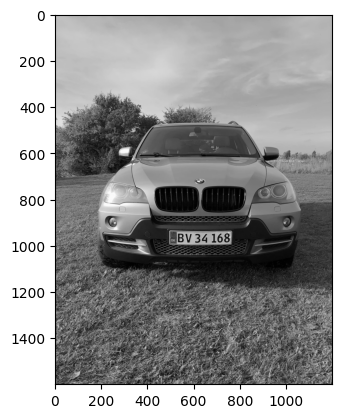

In [102]:
img  = cv2.imread("./misc/pictures/image_11.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR))

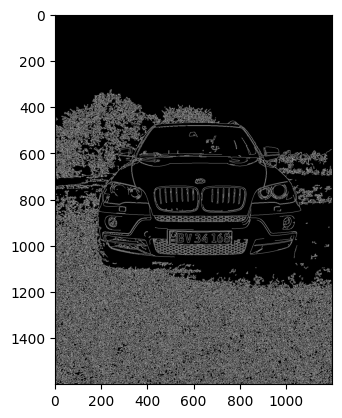

In [103]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(bfilter, 30, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [169]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
# contours = sorted(contours, key=cv2.contourArea, reverse=True)[:50]

In [185]:
sorted_list = sorted(contours, key=lambda x: len(cv2.approxPolyDP(x, 10, True)))[:50]

In [186]:
for x in sorted_list:
    print(len(x))

2
2
1
2
1
2
2
2
1
1
1
1
1
1
1
1
1
4
2
2
4
8
1
2
3
9
2
1
2
5
2
2
2
7
6
6
6
4
2
2
2
5
8
4
5
4
4
11
4
8


In [168]:
%timeit cv2.approxPolyDP(contours[0], 10, True)

29 µs ± 831 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [137]:
location = None
# for contour in contours:
approx = cv2.approxPolyDP(contours[0], 10, True)
if len(approx) == 4:
    location = approx
    # break

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [122]:
print(location)

[[[974 738]]

 [[991 769]]

 [[955 786]]

 [[941 757]]]


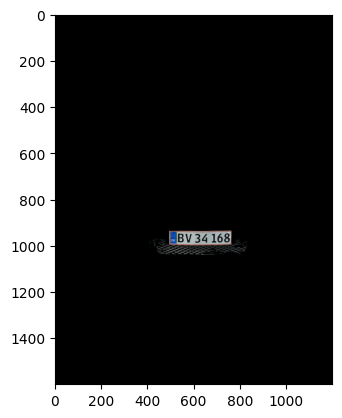

In [125]:
approx = cv2.approxPolyDP(contours[0], 10, True)
# print(approx.size, len(approx))
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [approx], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

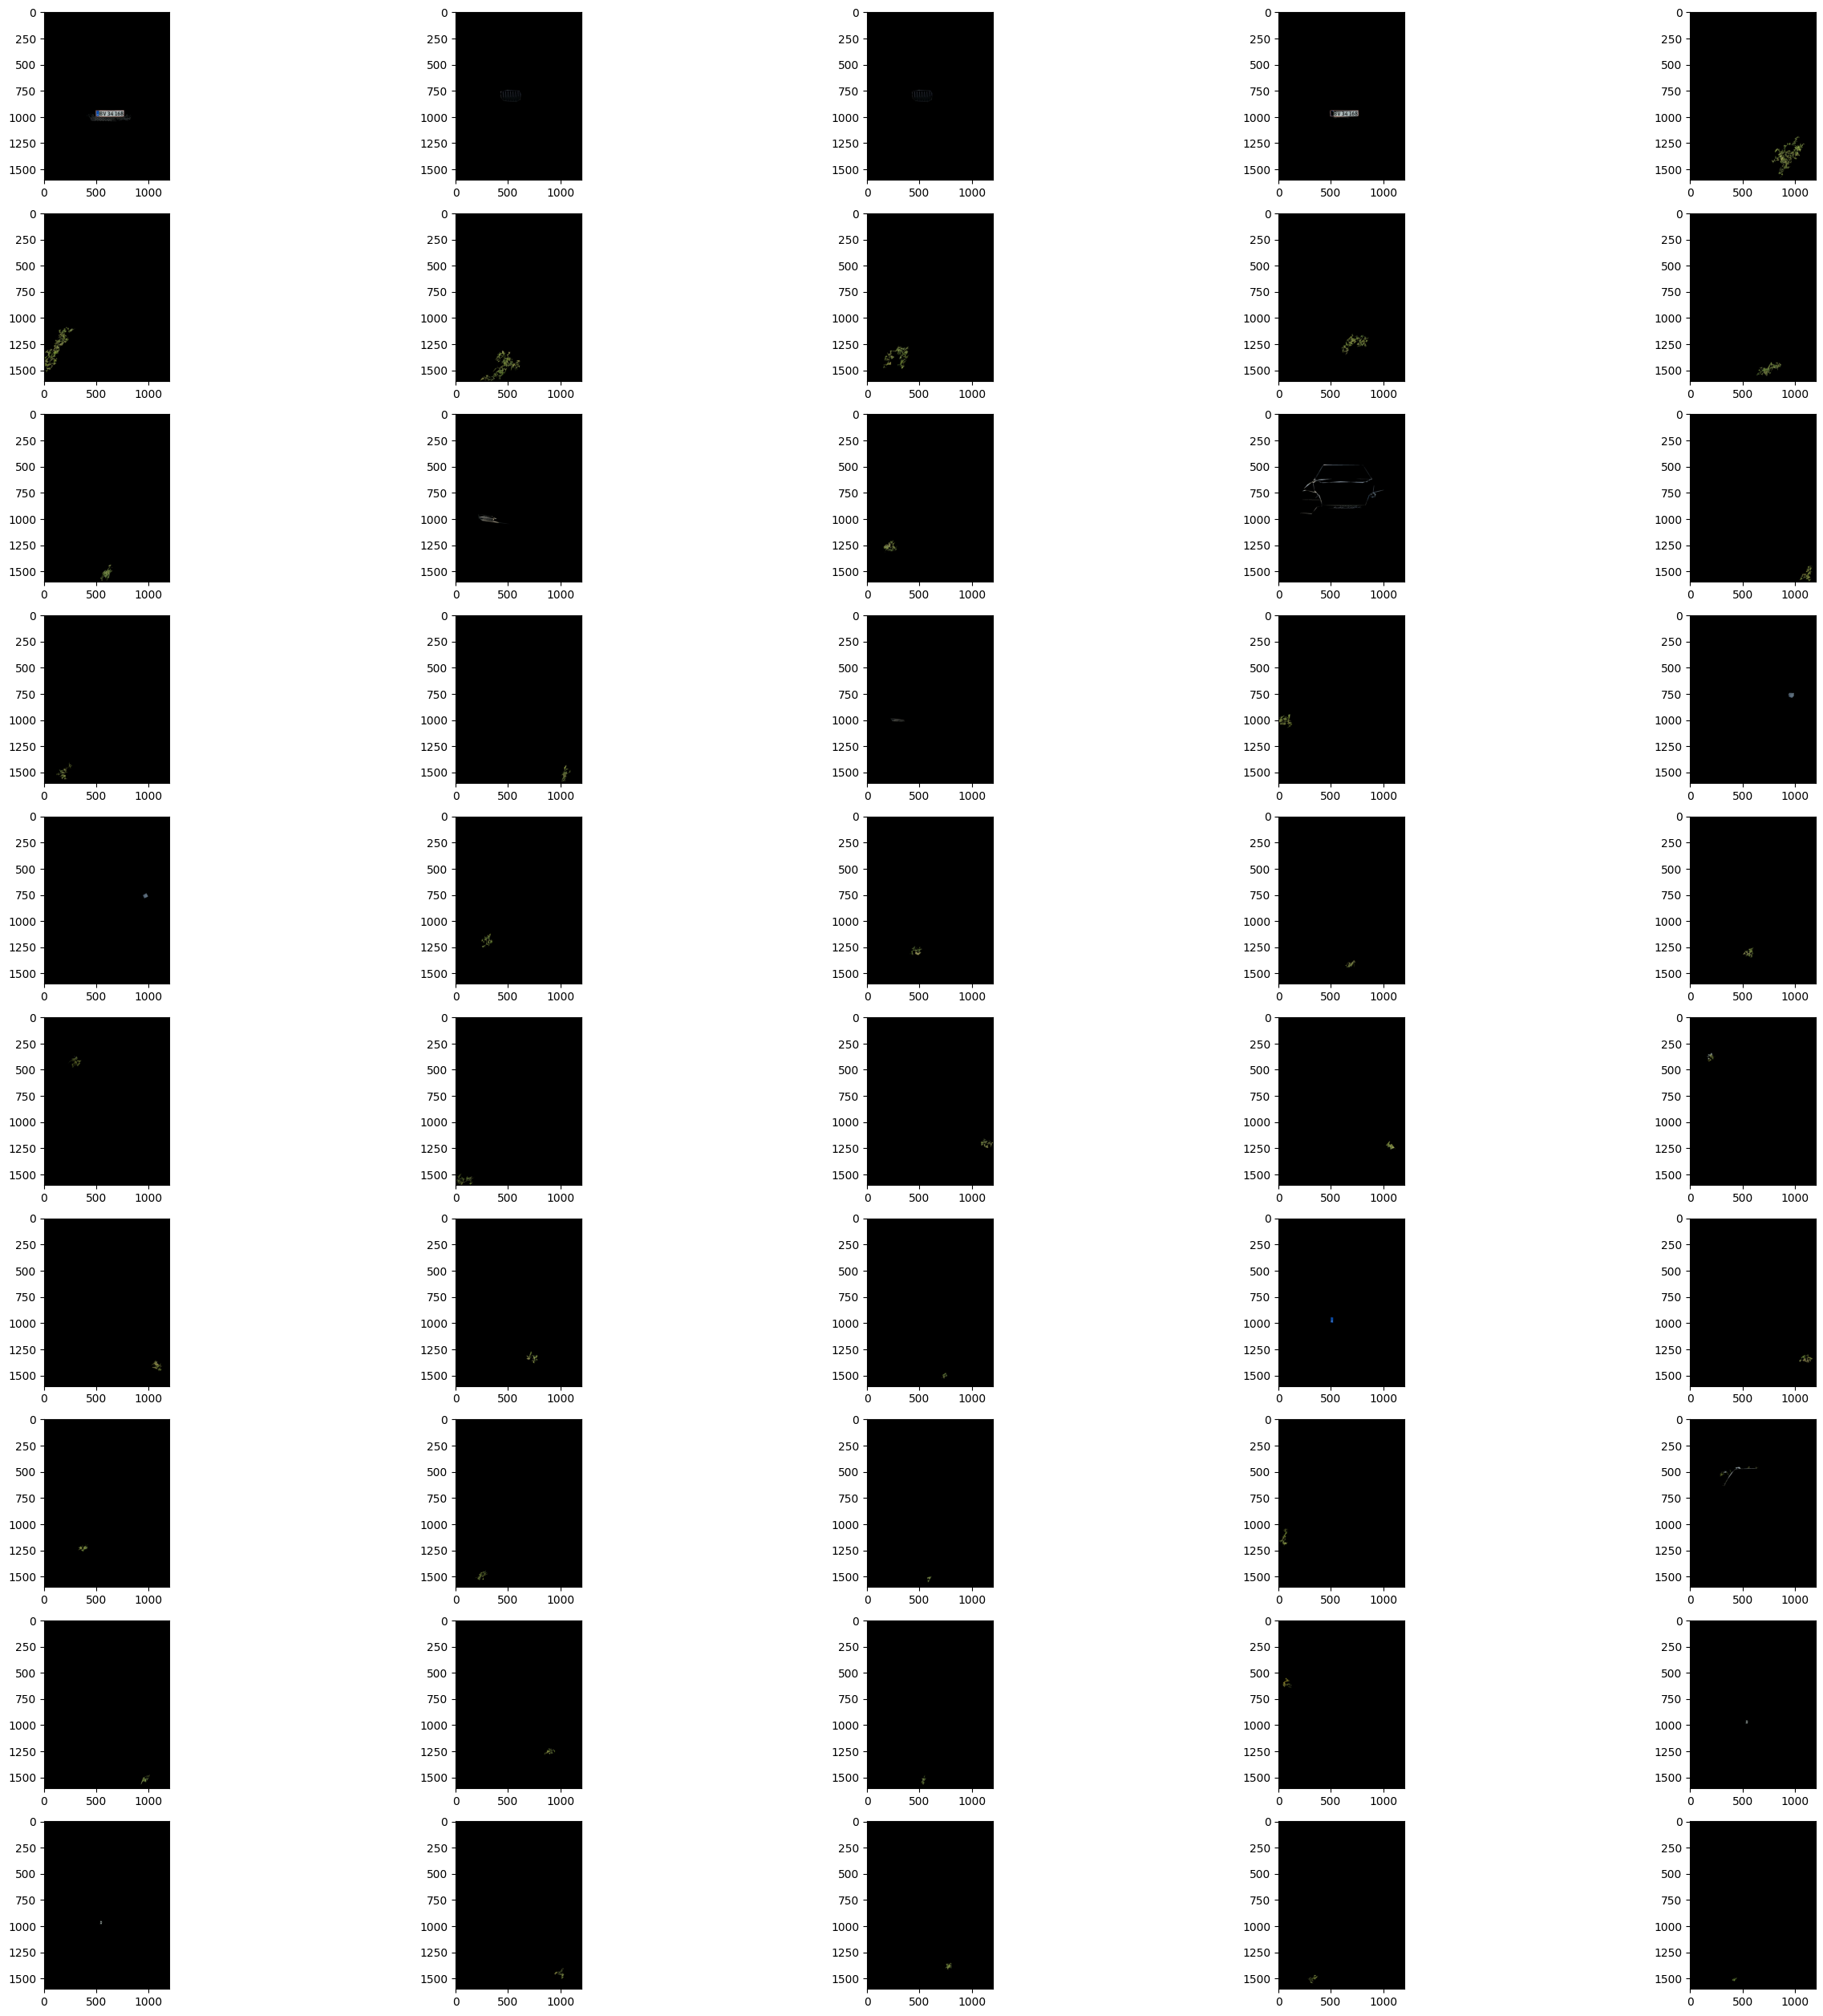

In [111]:
fig = plt.figure(figsize=(32, 32))
for i, contour in enumerate(contours):
    approx = cv2.approxPolyDP(contour, 10, True)
    # print(approx.size, len(approx))
    mask = np.zeros(gray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [approx], 0,255, -1)
    new_image = cv2.bitwise_and(img, img, mask=mask)
    fig.add_subplot(10, 5, i + 1)
    plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

    # plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [116]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2598: error: (-215:Assertion failed) reader.ptr != NULL in function 'cvDrawContours'


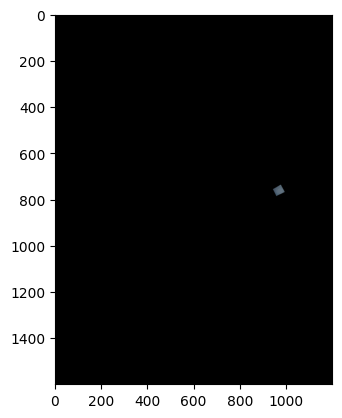

In [117]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [109]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

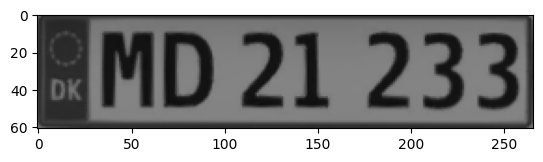

In [85]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [110]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[]

In [87]:
plate = result[-1][-2]
print(plate)

MD 21 233


In [75]:
plate.replace(" ", "")
regex = re.compile('[^a-zA-Z0-9]')

In [76]:
regex.sub('', plate)

'MN112'

In [208]:
import re
import cv2
import json
import imutils
import easyocr
import numpy as np

def get_license_plate(image):
    
    img  = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(bfilter, 30, 200)
    
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    # contours = sorted(contours, key=lambda x: len(cv2.approxPolyDP(x, 10, True)))[:50]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:50]

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)

        mask = np.zeros(gray.shape, np.uint8)
        new_image = cv2.drawContours(mask, [approx], 0,255, -1)
        new_image = cv2.bitwise_and(img, img, mask=mask)

        (x,y) = np.where(mask==255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        cropped_image = gray[x1:x2+1, y1:y2+1]

        reader = easyocr.Reader(['en'])
        result = reader.readtext(cropped_image)

        if len(result) != 0:
            formatted = result[-1][-2].replace(" ", "")
            if len(formatted) > 5 and any(char.isdigit() for char in formatted):
                # print(len(approx))
                break

    plate = result[-1][-2].replace(" ", "")
    regex = re.compile('[^a-zA-Z0-9]')

    return regex.sub('', plate)


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


'BV34168'

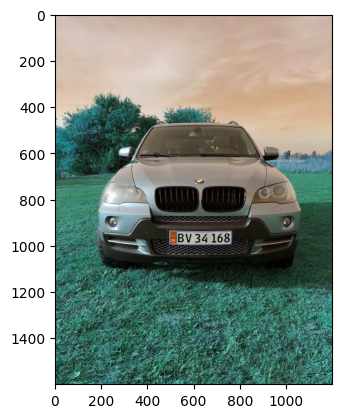

In [210]:
image = "./temp_licenseplates/image_11.jpg"

plt.imshow(cv2.imread(image))

get_license_plate(image)